In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

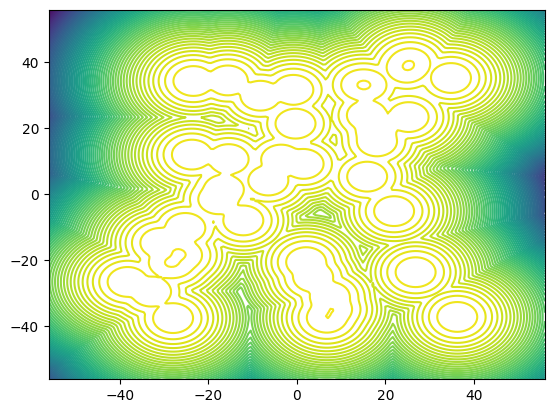

In [21]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0


if device == "cpu":
    use_gpu = False
else:
    use_gpu = True
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=use_gpu, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to(device)

### Helper Functions

In [22]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)

   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
        
    target.to(device)
    plt.show()
    return [fig]

In [23]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = -50 #torch.min(x, dim=0)[0]
    maxs = 50 #torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

## Function Definitions

### Estimated Reward Functions

In [24]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [25]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, 
                      randomness='different', in_dims=(0,0,None,None))(x, t, beta, 
                                                                       num_mc_samples, var_exploding=var_exploding)

In [29]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=200, var_exploding=True, richardson=False):
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### True Reward Functions

In [30]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [31]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    # samples_energy = true_Rt(x, t[0], beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

## SDE Tests

### Dataset

In [32]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/torch/_tensor.py:677: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1991.)
  LU, pivots, infos = torch._lu_with_info(


In [78]:
# normalize the dataset
init_num_samples = 2048
unnorm_true_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples, global_mins_init, global_maxs_init = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

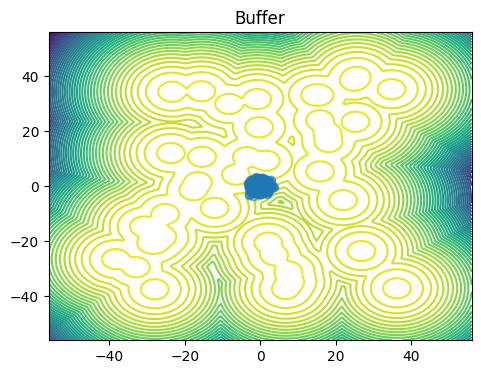

In [74]:
plot_dataset(unnorm_init_samples) # visualise the initial samples
plt.show()

### VE SDE

In [35]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            x.requires_grad = True
            score = self.score(x, 1-t, self.beta)
        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

In [36]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500).to(device)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
    return samples

In [37]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    pred_v = []
    true_v = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            pred_v.append(f)
            # true_v.append(true_grad_Rt(x, 1-t, beta))
    return torch.stack(samples), torch.stack(pred_v) # , torch.stack(true_v)

In [53]:
num_samples = 512
beta = 0.2

with torch.no_grad():
    target.convolve(torch.tensor(1000, device=torch.device('cpu')), 1)
    x1_samples = target.sample((num_samples,))
    target.reset()
    x1_samples_normalized = normalize(x1_samples)[0]

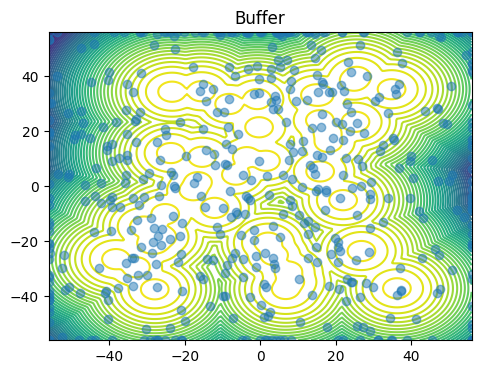

[<Figure size 1200x400 with 1 Axes>]

In [54]:
plot_dataset(x1_samples)

In [41]:
# ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
# samples = generate_samples(ve_reverse_sde, x1_samples_normalized)
samples, pred_vectors = integrate_sde(ve_reverse_sde, x1_samples_normalized, [0, 1], 0.001) #true_vectors

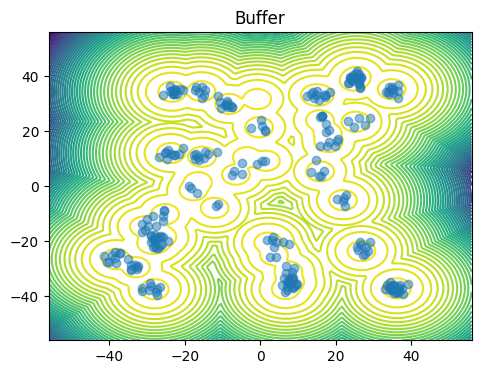

[<Figure size 1200x400 with 1 Axes>]

In [42]:
plot_dataset(unnormalize(samples[-1], global_mins_init, global_maxs_init))

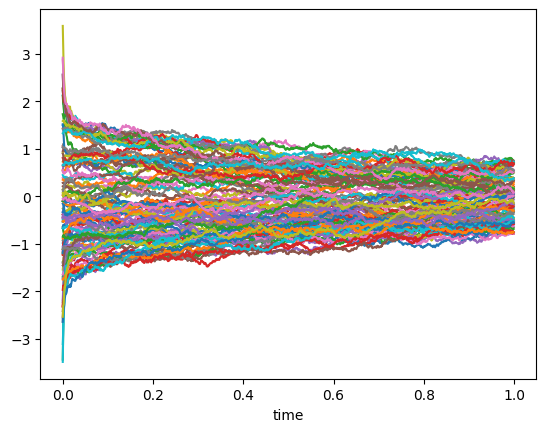

In [23]:
plt.plot(torch.arange(0, 1, 0.001), samples[:, :100, 0].detach().cpu())
plt.xlabel('time')
plt.show()

In [24]:
ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
# samples = generate_samples(ve_reverse_sde, x1_samples_normalized)
true_samples, true_vectors = integrate_sde(ve_reverse_sde, x1_samples_normalized, [0, 1], 0.001) #true_vectors

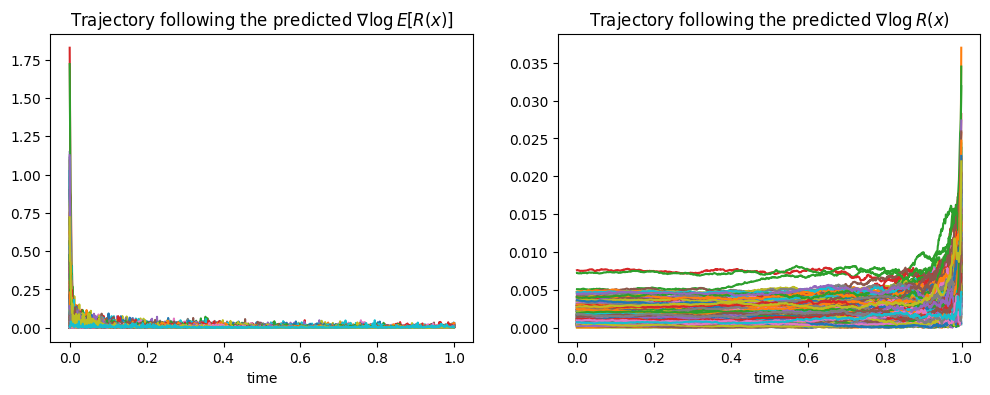

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# predicted 
traj_pred = torch.cumsum(pred_vectors, dim=-1)
axs[0].plot(torch.arange(0, 1, 0.001), torch.linalg.norm(traj_pred[:,:200], dim=-1).cpu())
axs[0].set_xlabel("time")
axs[0].set_title(r"Trajectory following the predicted $\nabla \log E[R(x)]$")


# true
traj_true = torch.cumsum(true_vectors, dim=-1)
axs[1].plot(torch.arange(0, 1, 0.001), torch.linalg.norm(traj_true[:,:200], dim=-1).cpu())
axs[1].set_xlabel("time")
axs[1].set_title(r"Trajectory following the predicted $\nabla \log R(x)$")

plt.show()

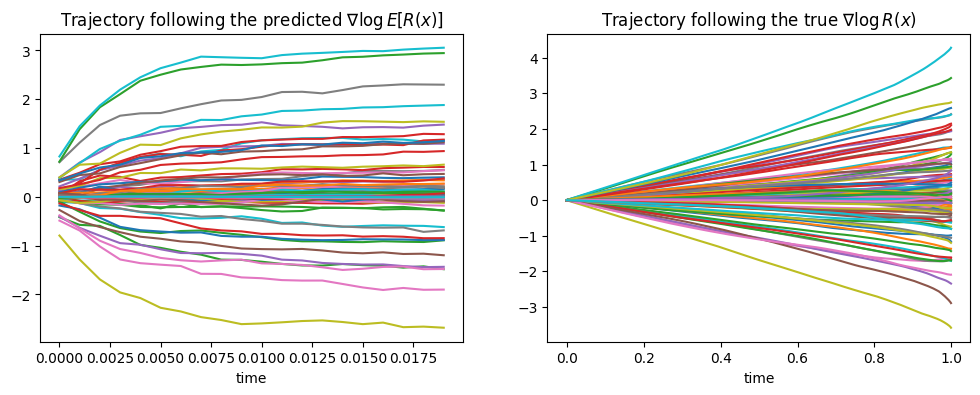

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# predicted 
# plt.plot(torch.arange(0, 1, 0.001), torch.cumsum(traj_norm_pred, dim=0).cpu())
axs[0].plot(torch.arange(0, 1, 0.001)[:20], torch.cumsum(pred_vectors[:20, :100, 0], dim=0).cpu())
axs[0].set_xlabel("time")
axs[0].set_title(r"Trajectory following the predicted $\nabla \log E[R(x)]$")


# true
# plt.plot(torch.arange(0, 1, 0.001), torch.cumsum(traj_norm_true, dim=0).cpu())
axs[1].plot(torch.arange(0, 1, 0.001), torch.cumsum(true_vectors[:, :100, 0], dim=0).cpu())
axs[1].set_xlabel("time")
axs[1].set_title(r"Trajectory following the true $\nabla \log R(x)$")

plt.show()

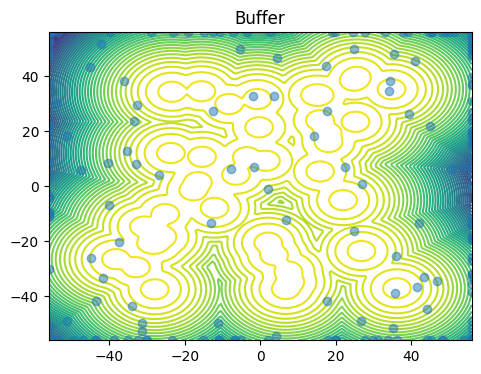

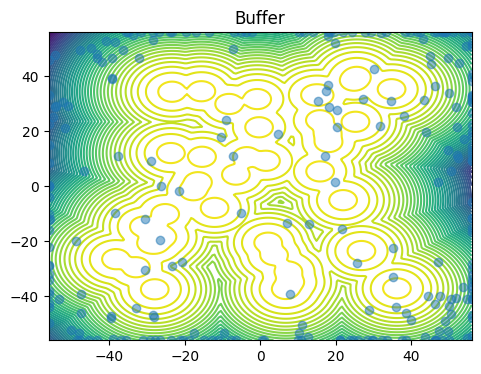

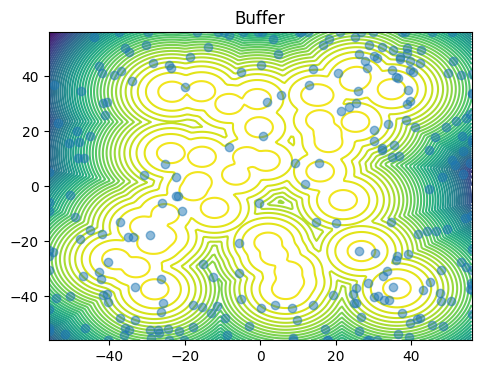

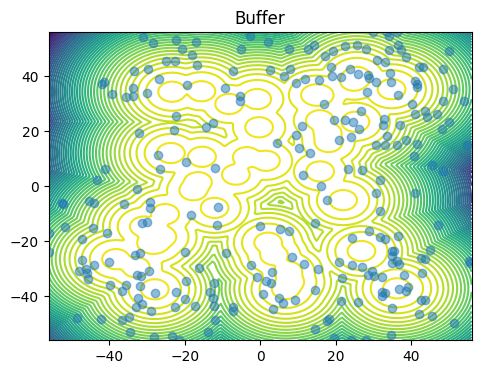

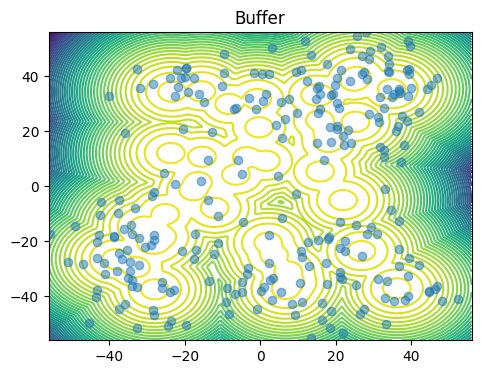

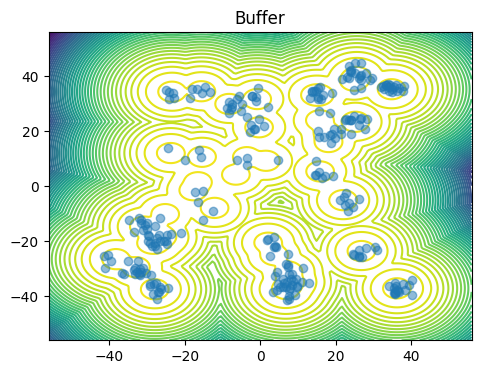

In [55]:
for i in range(0, true_samples.shape[0], 199):
    plot_dataset(unnormalize(samples[i], global_mins_init, global_maxs_init))

### Training

In [85]:
def reward_matching_loss_biased(vectorfield, x, t, beta):     
    h_t = beta * t.unsqueeze(1)
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t)

    estimated_scores = estimate_grad_Rt(noisy_x, t, beta)
    return ((estimated_scores - pred_scores)**2).mean()

In [86]:
def score_loss(vectorfield, x, t):
    h_t = beta * t.unsqueeze(1)
    # x(t)
    x_t = torch.normal(x, h_t ** 0.5)
    s_pred = vectorfield(x_t, t)

    s_true = - (x_t - x)/ h_t 
    return ((s_pred - s_true)**2).mean()    

In [87]:
beta = 0.2
vectorfield = MyMLP().to(device)
opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-4)

In [88]:
buffer = SimpleBuffer(2, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)


# x1_energy = target.log_prob(x1_samples).detach()
# buffer.add(x1_samples_normalized, x1_energy)
buffer.add(init_samples, init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 981.439148
Epoch 49 | Loss 986.224243
Epoch 98 | Loss 895.527039


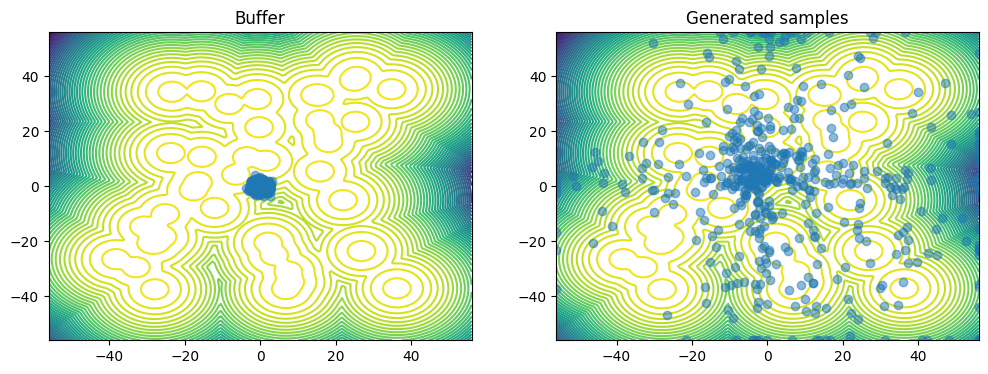

  1%|          | 1/100 [00:33<55:38, 33.72s/it]

Epoch 0 | Loss 480.643829
Epoch 49 | Loss 336.563110
Epoch 98 | Loss 308.999908


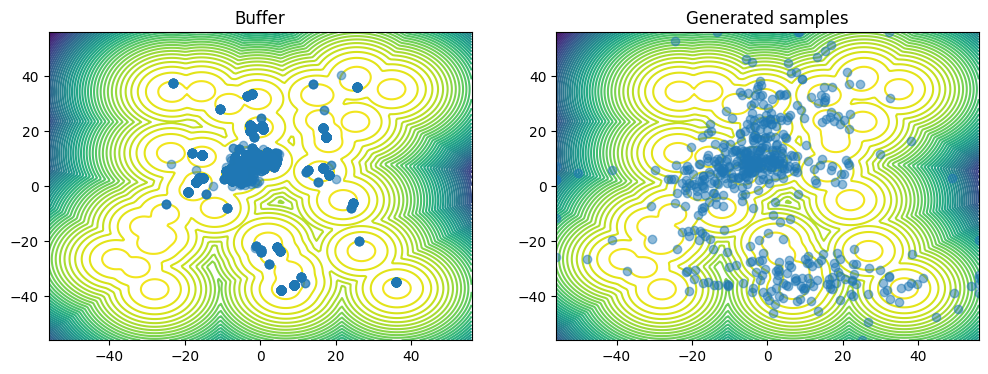

  2%|▏         | 2/100 [01:16<1:03:43, 39.01s/it]

Epoch 0 | Loss 397.792786
Epoch 49 | Loss 365.229889
Epoch 98 | Loss 375.425385


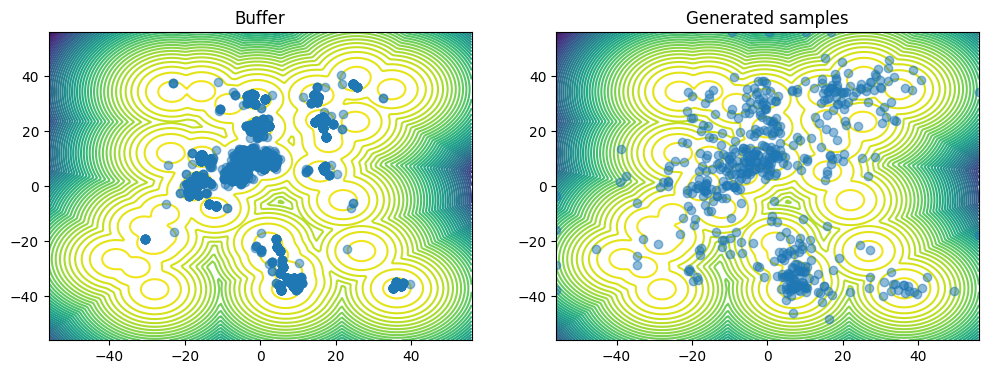

  3%|▎         | 3/100 [01:59<1:05:51, 40.74s/it]

Epoch 0 | Loss 390.352661
Epoch 49 | Loss 846.041260
Epoch 98 | Loss 241.914703


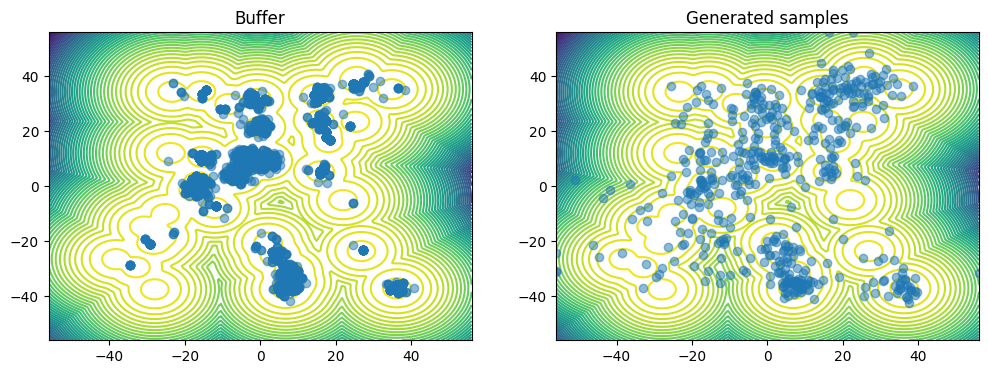

  4%|▍         | 4/100 [02:41<1:06:09, 41.35s/it]

Epoch 0 | Loss 427.654968
Epoch 49 | Loss 653.452332
Epoch 98 | Loss 230.678802


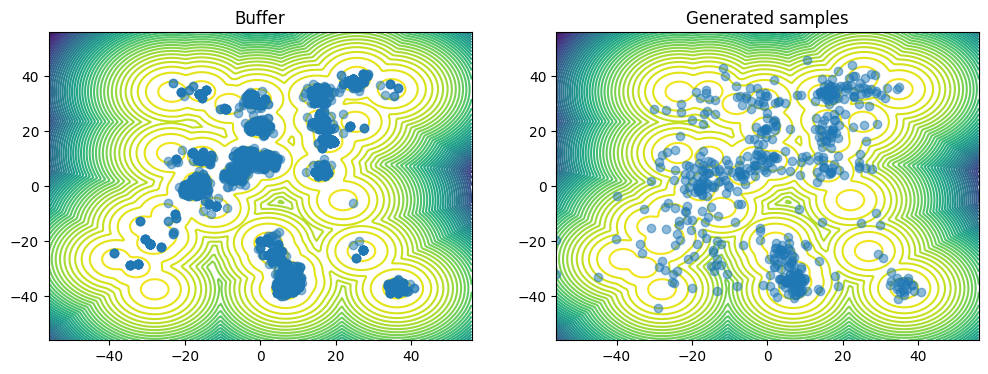

  5%|▌         | 5/100 [03:24<1:06:25, 41.96s/it]

Epoch 0 | Loss 290.678528
Epoch 49 | Loss 247.048080
Epoch 98 | Loss 197.653931


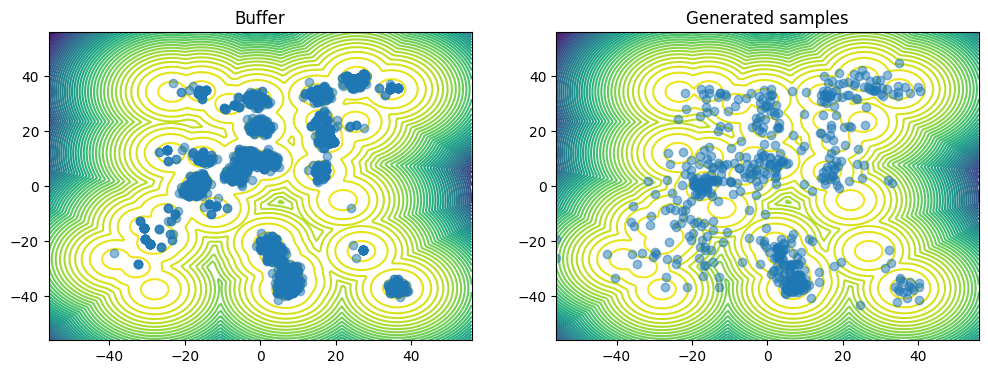

  6%|▌         | 6/100 [04:07<1:06:07, 42.21s/it]

Epoch 0 | Loss 457.401184


  6%|▌         | 6/100 [04:13<1:06:05, 42.19s/it]


KeyboardInterrupt: 

In [89]:
outer_epochs= 100
inner_epochs = 100

num_samples = 2048 

#train_dataset = TensorDataset(x1_samples_normalized.clone(), x1_energy.clone())
train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 
global_mins, global_maxs = global_mins_init, global_maxs_init


for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            # t = torch.rand(len(samples), device=device)

            # 80 % sample from (0, 0.1), 20% sample from (0.1, 1)
            # x0 is data
            low_time_t = (-0.1 * torch.rand(len(samples), device=device)) + 0.1
            high_time_t = (-0.9 * torch.rand(len(samples), device=device)) + 1.0
            
            mask = torch.rand(len(samples), device=device) < 0.8
            
            t = (low_time_t * mask) + (high_time_t * ~mask)

            loss = score_loss(vectorfield, samples, t) + reward_matching_loss_biased(vectorfield, samples, t, beta)
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the vector field
    ve_reverse_sde = VEReverseSDE(vectorfield, beta)
    generate_samples(ve_reverse_sde, x1_samples_normalized)
    samples = generate_samples(ve_reverse_sde, x1_samples_normalized)[-1]
    samples_energy = target.log_prob(unnormalize(samples, global_mins, global_maxs)).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    plot_dataset(unnormalize(train_dataset.tensors[0], global_mins, global_maxs), 
                 unnormalize(samples, global_mins, global_maxs))
    plt.show()
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)